In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
T = 30
HORIZON = 3
dateColumn = "Date" # Also "Date"
dateFormat = "%Y-%m-%d" # Also "%Y-%m-%d"

In [3]:
data = pd.read_csv("./data.csv")
data["Close"] = data["Adj Close"]
data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1, inplace = True)

if dateColumn == "Datetime":
    data[dateColumn] = data[dateColumn].apply(lambda x: x[:-6])
data[dateColumn] = pd.to_datetime(data[dateColumn], format = dateFormat)

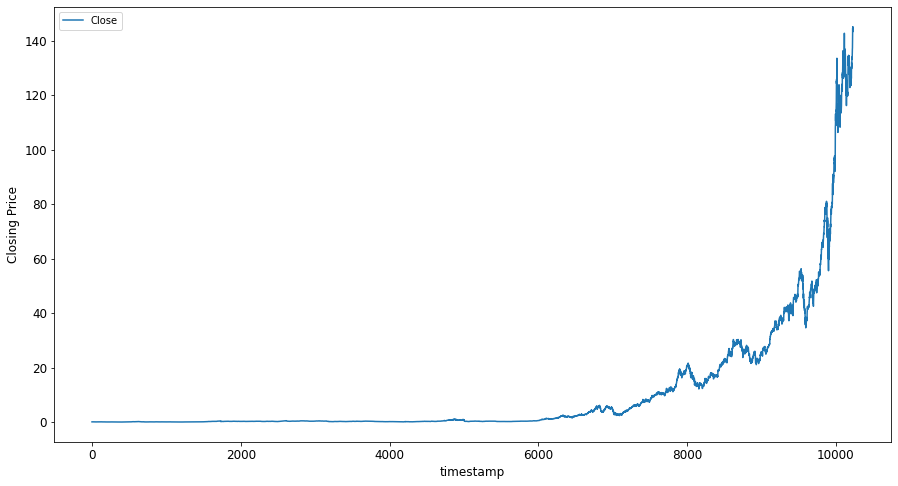

In [4]:
data.plot(y = "Close", subplots = True, figsize = (15, 8), fontsize = 12, use_index = True)
plt.xlabel("timestamp", fontsize = 12)
plt.ylabel("Closing Price", fontsize = 12)
plt.show()

In [5]:
data.set_index("Date", inplace = True)
data.head()

,Close
Date,
1980-12-12,0.10
1980-12-15,0.10
1980-12-16,0.09
1980-12-17,0.09
1980-12-18,0.09


In [6]:
trainRatio = 0.80
testRatio = 0.20

train, test = train_test_split(data, test_size = 1 - trainRatio, shuffle = False)
# trainTimestamps = train.Date
# testTimestamps = test.Date
# train.drop(["Date"], axis = 1, inplace = True)
# test.drop(["Date"], axis = 1, inplace = True)

In [7]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog = train, order = order, seasonal_order = seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 8184
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                6661.696
Date:                            Tue, 13 Jul 2021   AIC                         -13311.392
Time:                                    19:16:56   BIC                         -13269.351
Sample:                                         0   HQIC                        -13297.016
                                           - 8184                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0109      0.004     -3.037      0.002      -0.018      -0.004
ar.L2         -0.0405      0.004   

In [8]:
testShifted = test.copy()


for t in range(1, HORIZON + 1):
    testShifted["Close_t + " + str(t)] = testShifted["Close"].shift(-t)
    
testShifted = testShifted.dropna(how = "any")
testShifted.head(5)

,Close,Close_t + 1,Close_t + 2,Close_t + 3
Date,,,,
2013-05-24,13.96,13.85,13.96,14.17
2013-05-28,13.85,13.96,14.17,14.11
2013-05-29,13.96,14.17,14.11,14.14
2013-05-30,14.17,14.11,14.14,14.10
2013-05-31,14.11,14.14,14.10,13.96


In [9]:
%%time
trainingWindow = 720 # dedicate 30 days (720 hours) for training

trainTs = train["Close"]
testTs = testShifted

history = [x for x in trainTs]
history = history[(-trainingWindow): ]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(1000):
    model = SARIMAX(endog = history, order = order, seasonal_order = seasonal_order)
    modelFit = model.fit()
    yhat = modelFit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(testTs.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(testTs.index[t])
    print(t + 1, ": Predicted =", yhat, "Expected =", obs)

2013-05-24 00:00:00
1 : Predicted = [14.17 14.29 14.25] Expected = [13.964533805847168, 13.848150253295898, 13.958256721496582, 14.166241645812988]
2013-05-28 00:00:00
2 : Predicted = [14.09 14.06 14.12] Expected = [13.848150253295898, 13.958256721496582, 14.166241645812988, 14.10820770263672]
2013-05-29 00:00:00
3 : Predicted = [13.82 13.89 14.17] Expected = [13.958256721496582, 14.166241645812988, 14.10820770263672, 14.139265060424805]
2013-05-30 00:00:00
4 : Predicted = [14.03 14.3  14.55] Expected = [14.166241645812988, 14.10820770263672, 14.139265060424805, 14.095033645629885]
2013-05-31 00:00:00
5 : Predicted = [14.44 14.68 14.88] Expected = [14.10820770263672, 14.139265060424805, 14.095033645629885, 13.96327781677246]
2013-06-03 00:00:00
6 : Predicted = [14.36 14.57 14.39] Expected = [14.139265060424805, 14.095033645629885, 13.96327781677246, 13.75466251373291]
2013-06-04 00:00:00
7 : Predicted = [14.35 14.18 14.17] Expected = [14.095033645629885, 13.96327781677246, 13.754662513

2013-08-14 00:00:00
57 : Predicted = [15.46 15.45 15.43] Expected = [15.741394996643066, 15.722766876220703, 15.86233901977539, 16.033170700073242]
2013-08-15 00:00:00
58 : Predicted = [15.73 15.7  15.73] Expected = [15.722766876220703, 15.86233901977539, 16.033170700073242, 15.822547912597656]
2013-08-16 00:00:00
59 : Predicted = [15.69 15.73 15.66] Expected = [15.86233901977539, 16.033170700073242, 15.822547912597656, 15.863286018371582]
2013-08-19 00:00:00
60 : Predicted = [15.89 15.82 15.89] Expected = [16.033170700073242, 15.822547912597656, 15.863286018371582, 15.88222885131836]
2013-08-20 00:00:00
61 : Predicted = [15.95 16.02 15.82] Expected = [15.822547912597656, 15.863286018371582, 15.88222885131836, 15.820975303649902]
2013-08-21 00:00:00
62 : Predicted = [15.89 15.7  15.75] Expected = [15.863286018371582, 15.88222885131836, 15.820975303649902, 15.882549285888672]
2013-08-22 00:00:00
63 : Predicted = [15.67 15.72 15.58] Expected = [15.88222885131836, 15.820975303649902, 15.8

2013-11-01 00:00:00
113 : Predicted = [16.42 16.41 16.47] Expected = [16.421260833740234, 16.633460998535156, 16.592411041259766, 16.5454044342041]
2013-11-04 00:00:00
114 : Predicted = [16.41 16.47 16.38] Expected = [16.633460998535156, 16.592411041259766, 16.5454044342041, 16.27764892578125]
2013-11-05 00:00:00
115 : Predicted = [16.69 16.58 16.51] Expected = [16.592411041259766, 16.5454044342041, 16.27764892578125, 16.533971786499023]
2013-11-06 00:00:00
116 : Predicted = [16.49 16.42 16.53] Expected = [16.5454044342041, 16.27764892578125, 16.533971786499023, 16.486011505126953]
2013-11-07 00:00:00
117 : Predicted = [16.48 16.58 16.6 ] Expected = [16.27764892578125, 16.533971786499023, 16.486011505126953, 16.516498565673828]
2013-11-08 00:00:00
118 : Predicted = [16.38 16.41 16.46] Expected = [16.533971786499023, 16.486011505126953, 16.516498565673828, 16.536190032958984]
2013-11-11 00:00:00
119 : Predicted = [16.56 16.61 16.7 ] Expected = [16.486011505126953, 16.516498565673828, 16

2014-01-24 00:00:00
169 : Predicted = [17.59 17.58 17.62] Expected = [17.344213485717773, 17.48491668701172, 16.0873966217041, 15.904763221740724]
2014-01-27 00:00:00
170 : Predicted = [17.34 17.39 17.67] Expected = [17.48491668701172, 16.0873966217041, 15.904763221740724, 15.8739595413208]
2014-01-28 00:00:00
171 : Predicted = [17.53 17.8  17.77] Expected = [16.0873966217041, 15.904763221740724, 15.8739595413208, 15.900001525878906]
2014-01-29 00:00:00
172 : Predicted = [16.41 16.43 16.3 ] Expected = [15.904763221740724, 15.8739595413208, 15.900001525878906, 15.929543495178224]
2014-01-30 00:00:00
173 : Predicted = [15.94 15.83 15.84] Expected = [15.8739595413208, 15.900001525878906, 15.929543495178224, 16.160127639770508]
2014-01-31 00:00:00
174 : Predicted = [15.76 15.78 15.66] Expected = [15.900001525878906, 15.929543495178224, 16.160127639770508, 16.280824661254883]
2014-02-03 00:00:00
175 : Predicted = [15.92 15.8  15.97] Expected = [15.929543495178224, 16.160127639770508, 16.280

2014-04-15 00:00:00
225 : Predicted = [16.74 16.69 16.7 ] Expected = [16.549861907958984, 16.583417892456055, 16.772891998291016, 16.971952438354492]
2014-04-16 00:00:00
226 : Predicted = [16.51 16.52 16.7 ] Expected = [16.583417892456055, 16.772891998291016, 16.971952438354492, 16.988882064819336]
2014-04-17 00:00:00
227 : Predicted = [16.6  16.77 16.95] Expected = [16.772891998291016, 16.971952438354492, 16.988882064819336, 16.766815185546875]
2014-04-21 00:00:00
228 : Predicted = [16.94 17.12 17.12] Expected = [16.971952438354492, 16.988882064819336, 16.766815185546875, 18.14139747619629]
2014-04-22 00:00:00
229 : Predicted = [17.15 17.15 17.23] Expected = [16.988882064819336, 16.766815185546875, 18.14139747619629, 18.274639129638672]
2014-04-23 00:00:00
230 : Predicted = [16.99 17.08 17.15] Expected = [16.766815185546875, 18.14139747619629, 18.274639129638672, 18.982370376586918]
2014-04-24 00:00:00
231 : Predicted = [16.87 16.94 17.07] Expected = [18.14139747619629, 18.27463912963

2014-07-07 00:00:00
281 : Predicted = [21.47 21.58 21.66] Expected = [21.584930419921875, 21.44548225402832, 21.454479217529297, 21.37576484680176]
2014-07-08 00:00:00
282 : Predicted = [21.69 21.77 21.83] Expected = [21.44548225402832, 21.454479217529297, 21.37576484680176, 21.41624641418457]
2014-07-09 00:00:00
283 : Predicted = [21.53 21.61 21.59] Expected = [21.454479217529297, 21.37576484680176, 21.41624641418457, 21.69289207458496]
2014-07-10 00:00:00
284 : Predicted = [21.53 21.53 21.83] Expected = [21.37576484680176, 21.41624641418457, 21.69289207458496, 21.43873786926269]
2014-07-11 00:00:00
285 : Predicted = [21.37 21.68 21.64] Expected = [21.41624641418457, 21.69289207458496, 21.43873786926269, 21.31728172302246]
2014-07-14 00:00:00
286 : Predicted = [21.72 21.68 21.6 ] Expected = [21.69289207458496, 21.43873786926269, 21.31728172302246, 20.93717765808105]
2014-07-15 00:00:00
287 : Predicted = [21.65 21.58 21.38] Expected = [21.43873786926269, 21.31728172302246, 20.937177658

2014-09-24 00:00:00
337 : Predicted = [23.01 23.14 23.17] Expected = [22.99876594543457, 22.121767044067383, 22.772729873657227, 22.628070831298828]
2014-09-25 00:00:00
338 : Predicted = [23.13 23.17 23.28] Expected = [22.121767044067383, 22.772729873657227, 22.628070831298828, 22.772729873657227]
2014-09-26 00:00:00
339 : Predicted = [22.19 22.37 22.56] Expected = [22.772729873657227, 22.628070831298828, 22.772729873657227, 22.41786193847656]
2014-09-29 00:00:00
340 : Predicted = [22.92 23.08 23.2 ] Expected = [22.628070831298828, 22.772729873657227, 22.41786193847656, 22.580604553222656]
2014-09-30 00:00:00
341 : Predicted = [22.8  22.94 23.03] Expected = [22.772729873657227, 22.41786193847656, 22.580604553222656, 22.517311096191406]
2014-10-01 00:00:00
342 : Predicted = [22.92 23.   23.18] Expected = [22.41786193847656, 22.580604553222656, 22.517311096191406, 22.517311096191406]
2014-10-02 00:00:00
343 : Predicted = [22.53 22.73 22.75] Expected = [22.580604553222656, 22.517311096191

2014-12-12 00:00:00
393 : Predicted = [25.41 25.3  25.63] Expected = [24.91004943847656, 24.569528579711918, 24.233551025390625, 24.837404251098636]
2014-12-15 00:00:00
394 : Predicted = [24.82 25.17 25.37] Expected = [24.569528579711918, 24.233551025390625, 24.837404251098636, 25.572921752929688]
2014-12-16 00:00:00
395 : Predicted = [24.93 25.15 25.29] Expected = [24.233551025390625, 24.837404251098636, 25.572921752929688, 25.375417709350582]
2014-12-17 00:00:00
396 : Predicted = [24.47 24.65 24.7 ] Expected = [24.837404251098636, 25.572921752929688, 25.375417709350582, 25.63875389099121]
2014-12-18 00:00:00
397 : Predicted = [25.   25.03 24.89] Expected = [25.572921752929688, 25.375417709350582, 25.63875389099121, 25.54795455932617]
2014-12-19 00:00:00
398 : Predicted = [25.58 25.41 25.45] Expected = [25.375417709350582, 25.63875389099121, 25.54795455932617, 25.427635192871094]
2014-12-22 00:00:00
399 : Predicted = [25.21 25.26 25.02] Expected = [25.63875389099121, 25.54795455932617

2015-03-06 00:00:00
449 : Predicted = [28.63 29.08 29.06] Expected = [28.85317039489746, 28.976242065429688, 28.376840591430664, 27.8594913482666]
2015-03-09 00:00:00
450 : Predicted = [29.3  29.28 29.2 ] Expected = [28.976242065429688, 28.376840591430664, 27.8594913482666, 28.3631591796875]
2015-03-10 00:00:00
451 : Predicted = [28.95 28.9  28.74] Expected = [28.376840591430664, 27.8594913482666, 28.3631591796875, 28.16716194152832]
2015-03-11 00:00:00
452 : Predicted = [28.33 28.21 27.97] Expected = [27.8594913482666, 28.3631591796875, 28.16716194152832, 28.47711563110352]
2015-03-12 00:00:00
453 : Predicted = [27.74 27.53 27.25] Expected = [28.3631591796875, 28.16716194152832, 28.47711563110352, 28.953447341918945]
2015-03-13 00:00:00
454 : Predicted = [28.16 27.83 28.08] Expected = [28.16716194152832, 28.47711563110352, 28.953447341918945, 29.27936172485352]
2015-03-16 00:00:00
455 : Predicted = [27.84 28.09 28.58] Expected = [28.47711563110352, 28.953447341918945, 29.2793617248535

2015-05-27 00:00:00
505 : Predicted = [30.05 30.12 30.01] Expected = [30.218685150146484, 30.1591796875, 29.815893173217773, 29.87540054321289]
2015-05-28 00:00:00
506 : Predicted = [30.29 30.16 30.58] Expected = [30.1591796875, 29.815893173217773, 29.87540054321289, 29.742664337158203]
2015-05-29 00:00:00
507 : Predicted = [30.03 30.46 30.16] Expected = [29.815893173217773, 29.87540054321289, 29.742664337158203, 29.77927017211914]
2015-06-01 00:00:00
508 : Predicted = [30.24 29.96 29.37] Expected = [29.87540054321289, 29.742664337158203, 29.77927017211914, 29.6053466796875]
2015-06-02 00:00:00
509 : Predicted = [29.6  29.03 28.73] Expected = [29.742664337158203, 29.77927017211914, 29.6053466796875, 29.442848205566406]
2015-06-03 00:00:00
510 : Predicted = [29.17 28.87 29.18] Expected = [29.77927017211914, 29.6053466796875, 29.442848205566406, 29.24831962585449]
2015-06-04 00:00:00
511 : Predicted = [29.47 29.73 30.06] Expected = [29.6053466796875, 29.442848205566406, 29.24831962585449

2015-08-14 00:00:00
561 : Predicted = [26.59 26.56 26.87] Expected = [26.658740997314453, 26.934619903564453, 26.78288459777832, 26.44034194946289]
2015-08-17 00:00:00
562 : Predicted = [26.63 26.93 27.09] Expected = [26.934619903564453, 26.78288459777832, 26.44034194946289, 25.897789001464844]
2015-08-18 00:00:00
563 : Predicted = [27.23 27.37 27.33] Expected = [26.78288459777832, 26.44034194946289, 25.897789001464844, 24.313800811767575]
2015-08-19 00:00:00
564 : Predicted = [26.93 26.92 27.17] Expected = [26.44034194946289, 25.897789001464844, 24.313800811767575, 23.706880569458008]
2015-08-20 00:00:00
565 : Predicted = [26.44 26.72 26.65] Expected = [25.897789001464844, 24.313800811767575, 23.706880569458008, 23.849411010742188]
2015-08-21 00:00:00
566 : Predicted = [26.18 26.15 25.49] Expected = [24.313800811767575, 23.706880569458008, 23.849411010742188, 25.2172966003418]
2015-08-24 00:00:00
567 : Predicted = [24.29 23.75 23.81] Expected = [23.706880569458008, 23.849411010742188,

2015-11-03 00:00:00
617 : Predicted = [28.71 28.99 29.12] Expected = [28.17835235595703, 28.04731559753418, 27.91802215576172, 27.95034408569336]
2015-11-04 00:00:00
618 : Predicted = [28.45 28.6  28.58] Expected = [28.04731559753418, 27.91802215576172, 27.95034408569336, 27.83721160888672]
2015-11-05 00:00:00
619 : Predicted = [28.19 28.19 27.66] Expected = [27.91802215576172, 27.95034408569336, 27.83721160888672, 26.95987319946289]
2015-11-06 00:00:00
620 : Predicted = [27.91 27.38 27.87] Expected = [27.95034408569336, 27.83721160888672, 26.95987319946289, 26.8074893951416]
2015-11-09 00:00:00
621 : Predicted = [27.42 27.91 27.53] Expected = [27.83721160888672, 26.95987319946289, 26.8074893951416, 26.71744537353516]
2015-11-10 00:00:00
622 : Predicted = [28.33 27.94 28.1 ] Expected = [26.95987319946289, 26.8074893951416, 26.71744537353516, 25.937068939208984]
2015-11-11 00:00:00
623 : Predicted = [26.56 26.78 27.07] Expected = [26.8074893951416, 26.71744537353516, 25.937068939208984,

2016-01-26 00:00:00
673 : Predicted = [22.19 22.56 22.49] Expected = [23.0856990814209, 21.56881523132324, 21.723508834838867, 22.473865509033203]
2016-01-27 00:00:00
674 : Predicted = [23.44 23.36 23.93] Expected = [21.56881523132324, 21.723508834838867, 22.473865509033203, 22.26376724243164]
2016-01-28 00:00:00
675 : Predicted = [21.52 22.13 22.22] Expected = [21.723508834838867, 22.473865509033203, 22.26376724243164, 21.813552856445312]
2016-01-29 00:00:00
676 : Predicted = [22.32 22.42 22.33] Expected = [22.473865509033203, 22.26376724243164, 21.813552856445312, 22.245296478271484]
2016-02-01 00:00:00
677 : Predicted = [22.56 22.47 22.53] Expected = [22.26376724243164, 21.813552856445312, 22.245296478271484, 22.424036026000977]
2016-02-02 00:00:00
678 : Predicted = [22.18 22.24 22.2 ] Expected = [21.813552856445312, 22.245296478271484, 22.424036026000977, 21.82513236999512]
2016-02-03 00:00:00
679 : Predicted = [21.88 21.85 21.51] Expected = [22.245296478271484, 22.424036026000977,

2016-04-15 00:00:00
729 : Predicted = [25.87 26.01 26.26] Expected = [25.499799728393555, 24.949649810791016, 24.81732749938965, 24.8684024810791]
2016-04-18 00:00:00
730 : Predicted = [25.65 25.91 26.  ] Expected = [24.949649810791016, 24.81732749938965, 24.8684024810791, 24.599123001098636]
2016-04-19 00:00:00
731 : Predicted = [25.22 25.33 25.25] Expected = [24.81732749938965, 24.8684024810791, 24.599123001098636, 24.53180885314941]
2016-04-20 00:00:00
732 : Predicted = [24.93 24.86 24.91] Expected = [24.8684024810791, 24.599123001098636, 24.53180885314941, 24.39252471923828]
2016-04-21 00:00:00
733 : Predicted = [24.8  24.84 25.14] Expected = [24.599123001098636, 24.53180885314941, 24.39252471923828, 24.22307014465332]
2016-04-22 00:00:00
734 : Predicted = [24.65 24.95 25.21] Expected = [24.53180885314941, 24.39252471923828, 24.22307014465332, 22.70724105834961]
2016-04-25 00:00:00
735 : Predicted = [24.83 25.1  24.82] Expected = [24.39252471923828, 24.22307014465332, 22.7072410583

2016-07-06 00:00:00
785 : Predicted = [21.29 20.87 20.77] Expected = [22.310670852661133, 22.40642547607422, 22.579246520996094, 22.649311065673828]
2016-07-07 00:00:00
786 : Predicted = [21.89 21.78 21.86] Expected = [22.40642547607422, 22.579246520996094, 22.649311065673828, 22.7520751953125]
2016-07-08 00:00:00
787 : Predicted = [22.29 22.36 22.58] Expected = [22.579246520996094, 22.649311065673828, 22.7520751953125, 22.62362289428711]
2016-07-11 00:00:00
788 : Predicted = [22.65 22.86 22.74] Expected = [22.649311065673828, 22.7520751953125, 22.62362289428711, 23.0720329284668]
2016-07-12 00:00:00
789 : Predicted = [22.86 22.74 22.79] Expected = [22.7520751953125, 22.62362289428711, 23.0720329284668, 23.069700241088867]
2016-07-13 00:00:00
790 : Predicted = [22.63 22.68 22.52] Expected = [22.62362289428711, 23.0720329284668, 23.069700241088867, 23.31492042541504]
2016-07-14 00:00:00
791 : Predicted = [22.67 22.51 22.34] Expected = [23.0720329284668, 23.069700241088867, 23.3149204254

2016-09-23 00:00:00
841 : Predicted = [27.08 26.97 27.02] Expected = [26.46559333801269, 26.50550842285156, 26.55482482910156, 26.756763458251957]
2016-09-26 00:00:00
842 : Predicted = [26.34 26.41 26.25] Expected = [26.50550842285156, 26.55482482910156, 26.756763458251957, 26.341144561767575]
2016-09-27 00:00:00
843 : Predicted = [26.58 26.41 26.27] Expected = [26.55482482910156, 26.756763458251957, 26.341144561767575, 26.545429229736328]
2016-09-28 00:00:00
844 : Predicted = [26.39 26.25 26.02] Expected = [26.756763458251957, 26.341144561767575, 26.545429229736328, 26.420978546142575]
2016-09-29 00:00:00
845 : Predicted = [26.62 26.39 26.3 ] Expected = [26.341144561767575, 26.545429229736328, 26.420978546142575, 26.5336856842041]
2016-09-30 00:00:00
846 : Predicted = [26.1  26.02 26.61] Expected = [26.545429229736328, 26.420978546142575, 26.5336856842041, 26.545429229736328]
2016-10-03 00:00:00
847 : Predicted = [26.47 27.06 27.22] Expected = [26.420978546142575, 26.5336856842041, 26

2016-12-13 00:00:00
897 : Predicted = [26.8  26.88 26.5 ] Expected = [27.186798095703125, 27.186798095703125, 27.33548355102539, 27.37088966369629]
2016-12-14 00:00:00
898 : Predicted = [27.27 26.88 27.18] Expected = [27.186798095703125, 27.33548355102539, 27.37088966369629, 27.52901840209961]
2016-12-15 00:00:00
899 : Predicted = [26.8  27.09 26.77] Expected = [27.33548355102539, 27.37088966369629, 27.52901840209961, 27.60218811035156]
2016-12-16 00:00:00
900 : Predicted = [27.64 27.31 27.6 ] Expected = [27.37088966369629, 27.52901840209961, 27.60218811035156, 27.628145217895508]
2016-12-19 00:00:00
901 : Predicted = [27.03 27.33 27.66] Expected = [27.52901840209961, 27.60218811035156, 27.628145217895508, 27.44641494750977]
2016-12-20 00:00:00
902 : Predicted = [27.84 28.15 28.22] Expected = [27.60218811035156, 27.628145217895508, 27.44641494750977, 27.50069808959961]
2016-12-21 00:00:00
903 : Predicted = [27.91 27.98 27.99] Expected = [27.628145217895508, 27.44641494750977, 27.500698

2017-03-07 00:00:00
953 : Predicted = [33.01 34.05 33.97] Expected = [33.07185363769531, 32.94860076904297, 32.87274169921875, 32.98177719116211]
2017-03-08 00:00:00
954 : Predicted = [34.12 34.03 34.1 ] Expected = [32.94860076904297, 32.87274169921875, 32.98177719116211, 32.996002197265625]
2017-03-09 00:00:00
955 : Predicted = [32.84 32.94 33.  ] Expected = [32.87274169921875, 32.98177719116211, 32.996002197265625, 32.94622039794922]
2017-03-10 00:00:00
956 : Predicted = [32.97 33.03 33.22] Expected = [32.98177719116211, 32.996002197265625, 32.94622039794922, 33.294673919677734]
2017-03-13 00:00:00
957 : Predicted = [33.04 33.23 33.28] Expected = [32.996002197265625, 32.94622039794922, 33.294673919677734, 33.34919357299805]
2017-03-14 00:00:00
958 : Predicted = [33.19 33.24 33.43] Expected = [32.94622039794922, 33.294673919677734, 33.34919357299805, 33.18326568603516]
2017-03-15 00:00:00
959 : Predicted = [32.99 33.19 33.29] Expected = [33.294673919677734, 33.34919357299805, 33.18326

In [10]:
testTs = testTs[:len(predictions)]

evalDf = pd.DataFrame(predictions, columns=["t + "+str(t) for t in range(1, HORIZON + 1)])
evalDf["timestamp"] = test.index[0 : len(test.index) - HORIZON + 1][:len(predictions)]
evalDf = pd.melt(evalDf, id_vars = "timestamp", value_name = "prediction", var_name = "h")
evalDf["actual"] = np.array(np.transpose(testTs.drop("Close", axis = 1))).ravel()
# evalDf[["prediction", "actual"]] = scaler.inverse_transform(eval_df[["prediction", "actual"]])
evalDf.head()

,timestamp,h,prediction,actual
0,2013-05-24,t + 1,14.17,13.85
1,2013-05-28,t + 1,14.09,13.96
2,2013-05-29,t + 1,13.82,14.17
3,2013-05-30,t + 1,14.03,14.11
4,2013-05-31,t + 1,14.44,14.14


In [12]:
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

def mape(a, b): 
    mask = (a != 0)
    return (np.fabs(a - b) / a)[mask].mean()

erorMetrics = {
    "R2 Score: " : r2_score,
    "Mean Absolute Error" : mean_absolute_error,
    "Mean Squared Error" : mean_squared_error,
    "Mean Absolute Percentage Error" : mape
}


for t in range(1, HORIZON + 1):
    print(f"Predicting {t} units of time ahead")
    for metric in erorMetrics:
        score = erorMetrics[metric](
            evalDf[(evalDf.h == f"t + {t}")]["actual"],
            evalDf[(evalDf.h == f"t + {t}")]["prediction"]
        )
        score = np.round(score, 3)
        print(f"{metric:31} - ", score)
    print("=" * 40, end = "\n\n\n")

Predicting 1 units of time ahead
R2 Score:                       -  0.989
Mean Absolute Error             -  0.405
Mean Squared Error              -  0.301
Mean Absolute Percentage Error  -  0.017


Predicting 2 units of time ahead
R2 Score:                       -  0.983
Mean Absolute Error             -  0.516
Mean Squared Error              -  0.472
Mean Absolute Percentage Error  -  0.022


Predicting 3 units of time ahead
R2 Score:                       -  0.977
Mean Absolute Error             -  0.605
Mean Squared Error              -  0.646
Mean Absolute Percentage Error  -  0.026




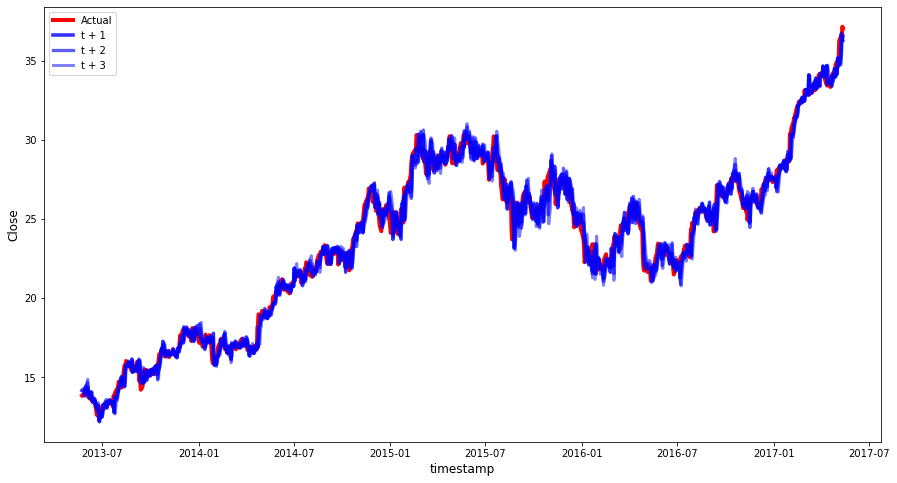

In [13]:
if(HORIZON == 1):
    ## Plotting single step forecast
    evalDf.plot(x = "timestamp", y = ["timestamp", "actual"], style=["r", "b"], figsize = (15, 8))

else:
    ## Plotting multi step forecast
    plotDf = evalDf[(evalDf.h == "t + 1")][["timestamp", "actual"]]
    for t in range(1, HORIZON + 1):
        plotDf[f"t + {t}"] = evalDf[(evalDf.h == f"t + {t}")]["prediction"].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    plt.plot(plotDf["timestamp"], plotDf["actual"], color = "red", linewidth = 4.0, label = "Actual")
    for t in range(1, HORIZON + 1):
        x = plotDf["timestamp"][t - 1:]
        y = plotDf["t + " + str(t)][0:len(x)]
        ax.plot(x, y, color = "blue", linewidth = 4 * math.pow(.9, t), alpha = math.pow(0.8, t), label = f"t + {t}")
    
    ax.legend(loc = "best")
    
plt.xlabel("timestamp", fontsize = 12)
plt.ylabel("Close", fontsize = 12)
plt.show()